# Modelling Neural Circuits

Based on Rosenbaum's book.

In [55]:
from dynamics import *

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (6, 4)

# Modeling Single Neurons

The $\emph{membrane potential}$ is the electric potential difference measured in the neuron with respect to the intercellular space, denoted as $V$. Normally, this is around -70 mV. 

When ions flow into the neuron through ion channels, the membrane potential changes. Above the $\emph{threshold potential}$ around $V\sim -55$ mV, the membrane potential spikes to around $0-10$ mV that lasts about $1-2$ ms. 

Spikes propagate down the neuron's axon, where they activate synapses. The synpases open ion channels on the postsynaptic neuron's membrane, causing a brief pulse of current (hence the postsynaptic membrane potential). 


## The Leaky Integrator Model

A neuron stores charges as ions. Hence, the membrane potential can be modeled as a leaky capacitor circuit $$C_m \frac{dV}{dt} = I(t)$$ where $V(t)$ is the membrane potential, $I(t)$ is the current across the membrane (into as positive), and $C_m$ is the (effective) capacitance of the membrane. (Note that $I(t)$ represents the average current per-unit area in reality, but we may interpret it as a single current.)

### The Leak Current

For most cortical neurons near rest ($V\approx -70mV$), the ion channels and pumps can be effectively $\mathbf{approximated}$ by a single current called the $\emph{leak current}$ $$I_L = - g_L(V-E_L)$$
where $g_L>0$ is the $\emph{leak conductance}$ and $E_L$ is the equilibrium or $\emph{resting potential}$ of the neuron. 

The equilibrium potential $E_L$ is the value of $V$ at which there is no leak current. When $V$ exceeds $E_L$, the leak current becomes negative and drives $V$ down. On the other hand, the leak current becomes positive and drives $V$ up. The leak conductance $g_L$ measures the strength of this pull toward $E_L$.

### The External Current

A current $I_x$ injected into the membrane through other source is the neuron's $\emph{external input current}$, which can be combined with the leak current to obtain the total membrane current
$$I=I_L+I_x$$

### The Leaky Integrator Model

Plugging this back to the leaky capacitor equation, we have the $\emph{leaky integrator model}$
$$C_m\frac{dV}{dt} = -g_L(V-E_L) + I_x(t)$$
This is a decent approximation of the subthreshold properties of certain neurons. By setting
$$\tau_m = \frac{C_m}{g_L}$$
and rescaling the input current $I_x\leftarrow I_x/g_L$, we have
$$\tau_m\frac{dV}{dt} = -(V-E_L) + I_x(t)$$
where $\tau_m$ is the $\emph{membrane time constant}$, which defines the timescale of membrane potential dynamics, as we shall see later in the exact solution. Typical neurons have membrane time constants around 5-20 ms. 

Note that $I_x(t)$ here is no longer a current, but has dimensions of electrical potential, but still proportional to the actual external current, reduced by the strength of the leak conductance.

There are two internal parameters related to the neuron properties: $\tau_m$ and $E_L$. There is also an external parameter space, $I_x(t)$. The initial conditions shall also be confirmed in specific scenarios. 

### Time-constant external current

When the external current $I_x(t)=I_0$ is constant, the model becomes an autonomous, linear differential euqation, with a standard exponential decay solution
$$V(t) = (V_0 - E_L - I_0) e^{-t/\tau_m} + E_L + I_0$$
where $V(0)=V_0$ is a initial membrane potential. This represents an exponential decay to $E_L + I_0$ with timescale $\tau_m$. 

We may simulate this initial value problem (IVP) using Euler's method and compare it with the exact solution. 

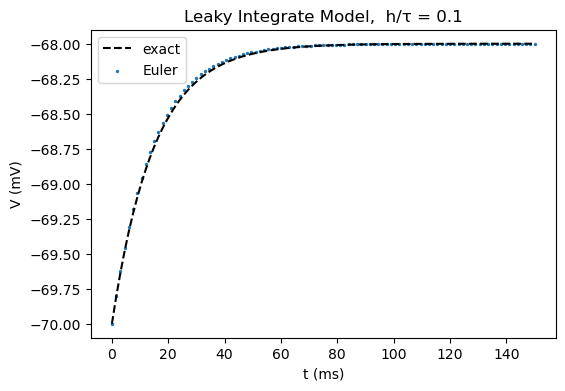

In [21]:
# Euler's method

# Parameters
E_L = -72
tau_m = 15

# Initial conditions
V0 = -70
I0 = 4

# Time
t0 = 0.0
T_end = 10 * tau_m

# Derivative function
f = lambda t, V: (- V + E_L + I0) / tau_m

# Exact solution
exact = lambda t: (V0 - E_L - I0) * np.exp(-t / tau_m) + E_L + I0

# Step sizes to try
hs = [0.1*tau_m]
# methods = ["Euler", "RK2", "RK4"]
methods = ["Euler"]

for h in hs:
    t_exact = np.arange(t0, T_end+h, h)
    plt.figure()
    plt.plot(t_exact, exact(t_exact), "k--", label="exact")
    for m in methods:
        T, P = dynamics_solve(f, D=1, t_0=t0, s_0=V0, h=h,
                              N=int((T_end-t0)/h), method=m)
        plt.scatter(T, P, label=m, s=2)
    plt.title(f"Leaky Integrate Model,  h/τ = {h/tau_m:.2g}")
    plt.xlabel("t (ms)")
    plt.ylabel("V (mV)")
    plt.legend()
    plt.savefig(f"LeakyIntegrate_h{h:.2g}.png", dpi=300)
    plt.show()


### Time-dependent external current

Now, $I_x(t)$ becomes time-dependent. The model becomes an inhomogeneous, linear differential equation. The solution now involves a convolution of $I_x(t)$ with a kernel
$$V(t) = (V0-E_L) e^{t/\tau_m} + E_L + (k*I_x)(t)$$
where $V(0) = V_0$ and $*$ denotes convolution. The kernel is defined as
$$k(s) = \frac{1}{\tau_m} e^{-s/\tau_m}\quad s\geq 0$$
$$k(s) = 0\quad s<0$$
or more compactly
$$k(s) = \frac{1}{\tau_m} e^{-s/\tau_m} H(s)$$
where $H(s)$ is the Heaviside function. $I_x(t)$ is assumed to be zero for negative $t$. 

When we consider the specific scenario of $V_0=E_L$ (or $t\gg \tau_m$) the solution simplifies
$$V(t) = E_L + (k * I_x)(t)$$
The intuition here is that changes in the external current gets integrated into the membrane potential then forgotten over a timescale of the membrane time constant. 

Again, we may simulate this IVP and compare it with the exact solution.


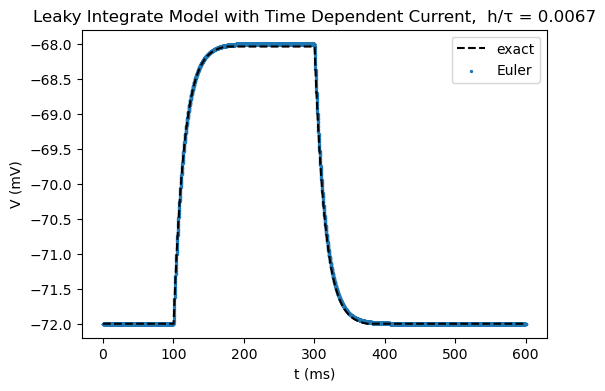

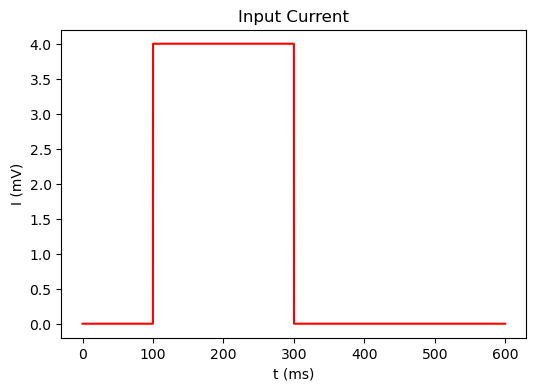

In [50]:
# Euler's method

# Parameters
E_L = -72
tau_m = 15

# Initial conditions
V0 = -72
# Time-dependent current
# example: a heaviside bump
I_x = lambda t: 4 if 100 <= t <= 300 else 0
I_x_vec = lambda t: np.where((t >= 100) & (t <= 300), 4, 0)

# Time
t0 = 0.0
T_end = 600
h = 0.1

# Derivative function
f = lambda t, V: (- V + E_L + I_x(t)) / tau_m

# Exact solution
t_exact = np.arange(t0, T_end+h, h)
s = np.arange(-5*tau_m, 5*tau_m, h)
k = (1/tau_m) * np.exp(-s/tau_m) * (s>=0)
exact = E_L + np.convolve(I_x_vec(t_exact), k, mode='same') * h

# methods = ["Euler", "RK2", "RK4"]
m = "Euler"
plt.figure()
plt.plot(t_exact, exact, "k--", label="exact")
T, V = dynamics_solve(f, D=1, t_0=t0, s_0=V0, h=h,
                    N=int((T_end-t0)/h), method=m)
plt.scatter(T, V, label=m, s=2)
plt.title(f"Leaky Integrate Model with Time Dependent Current,  h/τ = {h/tau_m:.2g}")
plt.xlabel("t (ms)")
plt.ylabel("V (mV)")
plt.legend()
plt.show()

# plot the input current
plt.figure()
plt.plot(t_exact, I_x_vec(t_exact), "r", label="input current")
plt.title("Input Current")
plt.xlabel("t (ms)")
plt.ylabel("I (mV)")
plt.show()


We may try different external currents to get some intuition.

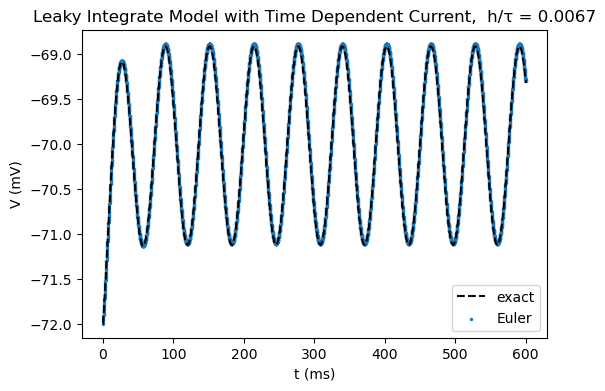

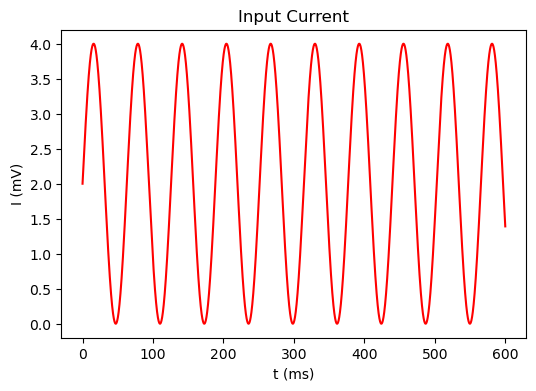

In [ ]:
# Euler's method

# Parameters
E_L = -72
tau_m = 15

# Initial conditions
V0 = -72
# Time-dependent current
# example: a sinusoidal input
I_x = lambda t: 2 * (1 + np.sin(0.1 * t))
# vectorized version
I_x_vec = lambda t: 2 * (1 + np.sin(0.1 * t))

# Time
t0 = 0.0
T_end = 600
h = 0.1

# Derivative function
f = lambda t, V: (- V + E_L + I_x(t)) / tau_m

# Exact solution
t_exact = np.arange(t0, T_end+h, h)
s = np.arange(-5*tau_m, 5*tau_m, h)
k = (1/tau_m) * np.exp(-s/tau_m) * (s>=0)
exact = E_L + np.convolve(I_x_vec(t_exact), k, mode='same') * h

# methods = ["Euler", "RK2", "RK4"]
m = "Euler"
plt.figure()
plt.plot(t_exact, exact, "k--", label="exact")
T, V = dynamics_solve(f, D=1, t_0=t0, s_0=V0, h=h,
                    N=int((T_end-t0)/h), method=m)
plt.scatter(T, V, label=m, s=2)
plt.title(f"Leaky Integrate Model with Time Dependent Current,  h/τ = {h/tau_m:.2g}")
plt.xlabel("t (ms)")
plt.ylabel("V (mV)")
plt.legend()
plt.show()

# plot the input current
plt.figure()
plt.plot(t_exact, I_x_vec(t_exact), "r", label="input current")
plt.title("Input Current")
plt.xlabel("t (ms)")
plt.ylabel("I (mV)")
plt.show()


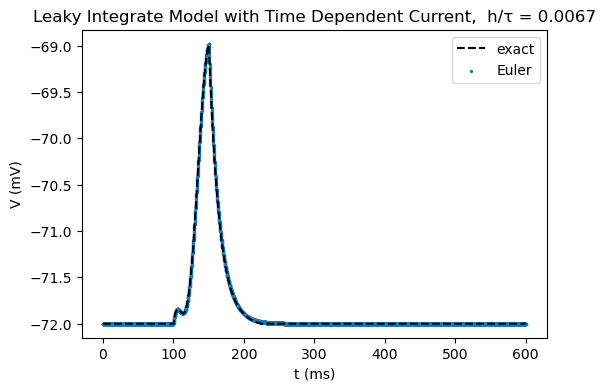

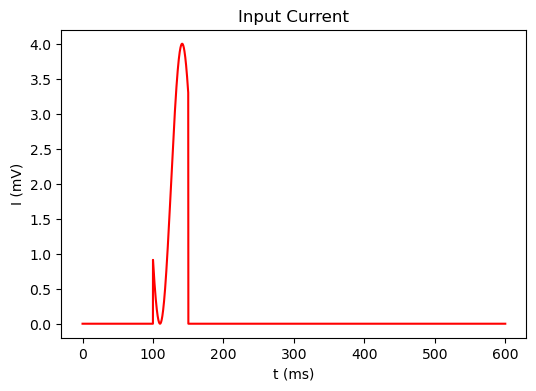

In [54]:
# Parameters
E_L = -72
tau_m = 15

# Initial conditions
V0 = -72
# Time-dependent current
# example: a sinusoidal bump after t=100ms, then zero again
I_x = lambda t: 2 * (1 + np.sin(0.1 * t)) if 100 <= t <= 150 else 0
# vectorized version
I_x_vec = lambda t: np.where((t >= 100) & (t <= 150), 2 * (1 + np.sin(0.1 * t)), 0)

# Time
t0 = 0.0
T_end = 600
h = 0.1

# Derivative function
f = lambda t, V: (- V + E_L + I_x(t)) / tau_m

# Exact solution
t_exact = np.arange(t0, T_end+h, h)
s = np.arange(-5*tau_m, 5*tau_m, h)
k = (1/tau_m) * np.exp(-s/tau_m) * (s>=0)
exact = E_L + np.convolve(I_x_vec(t_exact), k, mode='same') * h

# methods = ["Euler", "RK2", "RK4"]
m = "Euler"
plt.figure()
plt.plot(t_exact, exact, "k--", label="exact")
T, V = dynamics_solve(f, D=1, t_0=t0, s_0=V0, h=h,
                    N=int((T_end-t0)/h), method=m)
plt.scatter(T, V, label=m, s=2)
plt.title(f"Leaky Integrate Model with Time Dependent Current,  h/τ = {h/tau_m:.2g}")
plt.xlabel("t (ms)")
plt.ylabel("V (mV)")
plt.legend()
plt.show()

# plot the input current
plt.figure()
plt.plot(t_exact, I_x_vec(t_exact), "r", label="input current")
plt.title("Input Current")
plt.xlabel("t (ms)")
plt.ylabel("I (mV)")
plt.show()


## The Exponential Integrate and Fire (EIF) Model

When the membrane potential approaches -55 mV, sodium channels begin to open, causing an influx of positively charged sodium ions that raises the membrane potential higher. More sodium channels then open, creating a positive feedback loop and rapid upswing of the membrane potential. This upswing eventually stops when sodium channels close and potassium channels open, pulling the membrane potential back down toward resting potential. The Hudgkin-Huxley Model captures these dynamics in great detail, but expensive to simulate, so a simplified model is focused here. 

The rapid upswing is $\mathbf{approximated}$ by adding an exponential term to the leaky integrator. The subsequent reset is $\mathbf{approximated}$ by a simple rule: Every time $V(t)$ exceeds certain threshold $V_{th}$, we record a spike and reset $V(t)$ to $V_{re}$. This is the $\emph{exponential integrate-and-fire (EIF) model}$ (Fourcaud-Trocme et al. 2003),
$$ \tau_m \frac{dV}{dt} = -(V-E_L) + De^{(V-V_T)/D} + I_x(t)$$
$$ V(t) > V_{th} \implies \text{spike at time $t$ and $V(t)\leftarrow V_{re}$}$$
The second line here is the spiking rule we described. It defines a class of \emph{integrate-and-fire (IF)} models. The term
$$ \Phi(V) = De^{(V-V_T)/D}$$
models the current induced by the opening of sodium channels that initiates the upswing of an action potential. 

The parameters $V_T$ should be chosen near the potential at which action potential initiation begins--when the sodium channels positive feedback loop starts. Normally, $V_T\approx-55mV$. 

Other parameters must satisfy 
$$V_{re},V_T < V_{th}$$
$$D>0$$
Typically, $V_{re}$ is close to $E_L$. For more realistic model, $V_{th} \approx 0-10$ mV, but smaller values will not significantly influence spike timing.

### The leaky integrate-and-fire (LIF) model

A simpler model omits $\Phi(V)$ term and only records a spike and resets the membrane potential after $V$ exceeds $V_T\approx -55mV$. The LIF model is one of the most widely used models in computational neuroscience. 

### Comparison to the Hodgkin-Huxley (HH) model

A detailed mathematical analysis shows that the membrane potential dynamics of HH model during the upswing of an action potential are accurately approximated by the EIF model (Jolivet, Lewis, and Gerstner 2004; Chapter 5.2 of Gerstner et al. 2014). Actual experiments also verified that the EIF model accurately captures the upswing of an action potential in real neurons (Badel et al. 2008). For these reasons, EIF model is an ideal one-dimensional neuron model (Fourcaud-Trocme et al. 2003; Jolivet et al. 2004; Gerstner et al. 2014) (1D here means the model is a 1D ODE). 

### Simulation of subthreshold and superthreshold current injection in EIF neuron

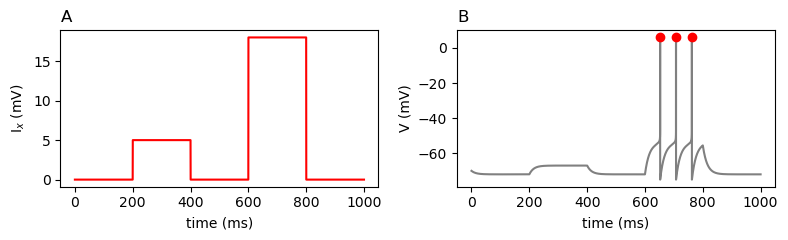

In [62]:
# Time
t_0 = 0.0
T_end = 1000
h = 0.1
steps = int((T_end-t0)/h)
T = np.linspace(t_0, t_0 + steps * h, steps + 1)

# Neuron parameters
N = 1 # one neuron
E_L = -72
tau_m = 15
V_th = 5
V_re = -75
V_T = -55
D = 2

# Initial conditions
V0 = -70
I_x=np.zeros_like(T)
I_x[(T>=200) & (T<=400)]=5
I_x[(T>=600) & (T<=800)]=18

# Derivative function
f = lambda n, V: (- V + E_L + I_x[n] + D * np.exp(V - V_T) / D) / tau_m

# Initialize voltage
V = np.zeros((steps + 1, N)) if N > 1 else np.zeros(steps + 1)
V[0] = V0

# Statistics storage
SpikeTimes = np.array([])

for n in range(steps):
    V[n + 1] = V[n] + h * f(n, V[n])
    if V[n + 1] >= V_th:
        V[n + 1] = V_re
        V[n] = V_th
        SpikeTimes = np.append(SpikeTimes, T[n+1])
        
plt.subplots(1,2,figsize=(8, 2.5))

plt.subplot(1,2,1)
plt.plot(T,I_x,color='r')
plt.xlabel('time (ms)')
plt.ylabel('I$_x$ (mV)')
plt.title('A',loc='left')


plt.subplot(1,2,2)
plt.plot(T,V,color='gray')
plt.plot(SpikeTimes,V_th+1+0*SpikeTimes,'ro')
plt.xlabel('time (ms)')
plt.ylabel('V (mV)')
plt.title('B',loc='left')
plt.tight_layout()